In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as mb
mb.set_matplotlib_formats('svg')

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cuda', index=0)

In [7]:
transform = T.Compose([T.ToTensor(),
            T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])] )

trainset = torchvision.datasets.CIFAR10('./data', train = True, download = True,transform = transform)
devset = torchvision.datasets.CIFAR10('./data', train = False, download = True,transform = transform)
# transform to dataloaders
batchsize    = 32
train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
dev_loader   = DataLoader(devset,  batch_size=len(devset)) # note: devtest in batches!



Files already downloaded and verified
Files already downloaded and verified


In [21]:
len(devset)

10000

In [8]:
X, y = next(iter(train_loader))
X.shape

torch.Size([32, 3, 32, 32])

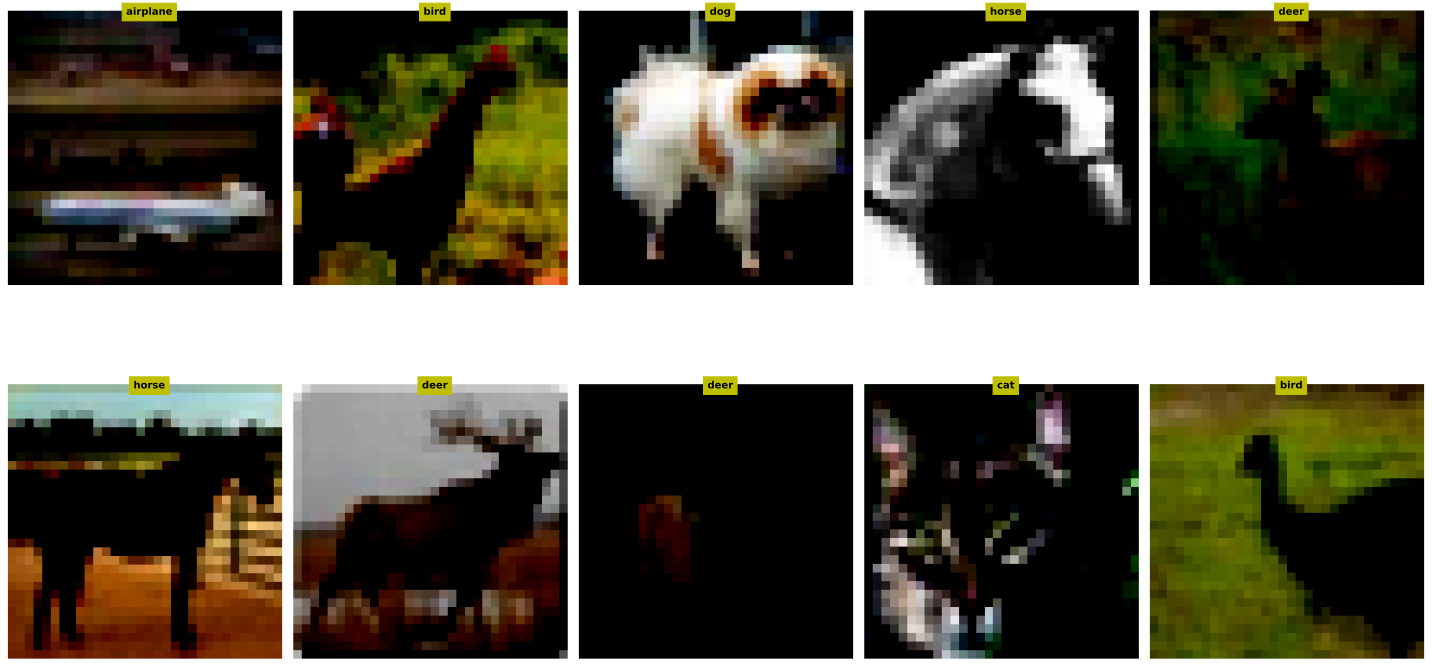

In [9]:
fig, axs = plt.subplots(2, 5, figsize = (20, 12))
for (i, ax) in enumerate(axs.flatten()):
    randidx = np.random.choice(batchsize)
    img = X[i,:,:,:]
    img = img.permute(1, 2, 0).numpy()
    label = trainset.classes[y[i]]
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    ax.text(16, 0, label, ha = 'center', fontweight = 'bold', color = 'k', backgroundcolor = 'y')

plt.tight_layout()
plt.show()




In [10]:
def makeTheAE():

    class AE(nn.Module):

        def __init__(self):
            super().__init__()

            self.enc = nn.Sequential(
                                     nn.Conv2d(3, 16, 4, padding = 1, stride = 2),
                                     nn.ReLU(),
                                     nn.Conv2d(16, 32, 4, padding = 1, stride = 2),
                                     nn.ReLU(),
                                     nn.Conv2d(32, 64, 4, padding = 1, stride = 2),
                                     nn.ReLU()
                                     )
            self.dec = nn.Sequential(
                                     nn.ConvTranspose2d(64, 32, 4, padding = 1, stride = 2),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(32, 16, 4, padding = 1, stride = 2),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(16, 3, 4, padding = 1, stride = 2)
                                    )
        def forward(self, x):
            x = self.enc(x)
            x = self.dec(x)

            return x

    net = AE()
    net.to(device)

    lossfun = nn.MSELoss()

    optimizer = torch.optim.Adam(net.parameters(), lr = .001)

    return net, lossfun, optimizer

In [12]:
!pip install torchsummary
from torchsummary import summary
summary(makeTheAE()[0], (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             784
              ReLU-2           [-1, 16, 16, 16]               0
            Conv2d-3             [-1, 32, 8, 8]           8,224
              ReLU-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 4, 4]          32,832
              ReLU-6             [-1, 64, 4, 4]               0
   ConvTranspose2d-7             [-1, 32, 8, 8]          32,800
              ReLU-8             [-1, 32, 8, 8]               0
   ConvTranspose2d-9           [-1, 16, 16, 16]           8,208
             ReLU-10           [-1, 16, 16, 16]               0
  ConvTranspose2d-11            [-1, 3, 32, 32]             771
Total params: 83,619
Trainable params: 83,619
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

In [36]:
def trainAE():

    net, lossfun, optimizer = makeTheAE()

    numepochs = 50

    trainLoss = torch.zeros(numepochs)
    testLoss = torch.zeros(numepochs)

    for epochi in range(numepochs):
        net.train()
        batchLoss = []

        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            yHat = net(X)
            loss = lossfun(yHat, X)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())

        trainLoss[epochi] = np.mean(batchLoss)

        net.eval()
        X_t, y = next(iter(dev_loader))
        X_t = X_t.to(device)
        y = y.to(device)
        with torch.inference_mode():
            yHat_test = net(X_t)
#             print(f'yHat : {yHat.shape}, X : {X_t.shape}')
            testLoss[epochi] = lossfun(yHat_test, X_t).item()


    return trainLoss, testLoss, net

In [37]:
trainLoss, testLoss, net = trainAE()

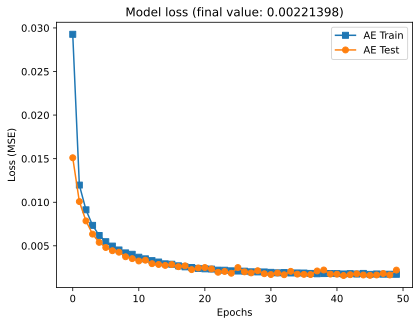

In [39]:
plt.plot(trainLoss,'s-',label='AE Train')
plt.plot(testLoss,'o-',label='AE Test')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model loss (final value: %g)'%testLoss[-1])
plt.legend()

plt.show()

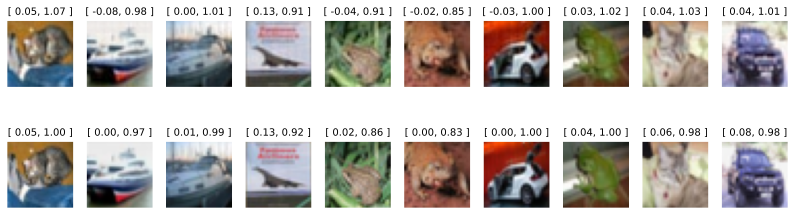

In [42]:
## show some random examples

# get some data
X,y = next(iter(dev_loader))

# forward pass and loss
net.cpu()
net.eval() # switch to test mode
yHat = net(X)


fig,axs = plt.subplots(2,10,figsize=(14,4))

for i in range(10):
  pic = yHat[i,:,:,:].detach().numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization
  axs[0,i].imshow(pic)
  axs[0,i].set_title(f'[ {np.min(pic):.2f}, {np.max(pic):.2f} ]',fontsize=10)
  axs[0,i].axis('off')

  pic = X[i,:,:,:].detach().numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization
  axs[1,i].imshow(pic)
  axs[1,i].set_title(f'[ {np.min(pic):.2f}, {np.max(pic):.2f} ]',fontsize=10)
  axs[1,i].axis('off')

  
plt.show()